In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def get_ERA5(era_pl, era_srfc, indic):
    
    dic = {}

    dic['q_col'] = []
    dic['u_col'] = []
    dic['r_col'] = []
    dic['v_col'] = []
    
    dic['q_col_s'] = []
    dic['u_col_s'] = []
    dic['r_col_s'] = []
    dic['v_col_s'] = []
    dic['u925_s'] = []
    dic['u650_s'] = []
    dic['q925_s'] = []
    dic['q700_s'] = []
    dic['tcwv_s'] = []
    dic['CAPE_s'] = []
    
    ### single values
    dic['tcwv'] = []
    dic['CAPE'] = []
    dic['dates'] = []
    dic['tmin'] = []
    dic['tmean'] = []
    dic['t10'] = []
    dic['area'] = []
    dic['area70'] = []
    dic['lat'] = []
    dic['lon'] = []
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    
    
    
    for id, date in enumerate(indic.date):
        
        print('Doing', date)
        

#         getera_pl =np.where((era_pl['time.day']==(indic['date'])[id].day) & (era_pl['time.month']==indic.month[id]) 
#                             & (era_pl['time.year']==indic.year[id]) & (era_pl['time.hour']==12))
        
#         getera_sf =np.where((era_srfc['time.day']==(indic['date'])[id].day)  & (era_srfc['time.year']==indic.year[id]) 
#                             & (era_srfc['time.month']==indic.month[id]) & (era_srfc['time.hour']==12))

        time = str(date.year)+str(date.month).zfill(2)+str(date.day).zfill(2)+'T12'
        stormtime = str(date.year)+str(date.month).zfill(2)+str(date.day).zfill(2)+'T15'
      
        try:
            era_day_pl = era_pl.sel(time=time).isel(time=0)
        except (TypeError, IndexError, KeyError):
            print('Era missing:', date)
#             for k in dic.keys():
#                 dic[k].append(np.nan)
            continue
    
       
        era_day_sf = era_srfc.sel(time=time).isel(time=0)
        try:
            era_day_sft = era_srfc.sel(time=stormtime).isel(time=0)
        except IndexError:
            continue
        era_day_plt = era_pl.sel(time=stormtime).isel(time=0)

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['dates'].append(date)
        dic['lat'].append(elat)
        dic['lon'].append(elon)
        #ipdb.set_trace()
        point = era_day_sf.sel(latitude=elat, longitude=elon, method='nearest')
        
        posx = int(np.where(era_day_sf.longitude == point.longitude)[0])
        posy = int(np.where(era_day_sf.latitude == point.latitude)[0])
                    
#         xxx = 0
#         yy = slice(posy-xx,posy+xx)
#         xx = slice(posx-xx,posx+xx)
        yy = posy
        xx = posx
        
        try:
            dic['u925'].append(np.asscalar((era_day_pl['u'].isel(latitude=yy, longitude=xx).sel(level=925).mean().values)))
        except ValueError:
            continue
        #ipdb.set_trace()
        dic['u650'].append(np.asscalar((era_day_pl['u'].isel(latitude=yy, longitude=xx).sel( level=650).mean().values)))
        dic['q925'].append(np.asscalar((era_day_pl['q'].isel(latitude=yy, longitude=xx).sel( level=925).mean().values)))
        dic['q700'].append(np.asscalar((era_day_pl['q'].isel(latitude=yy, longitude=xx).sel( level=700).mean().values)))
        dic['CAPE'].append(np.asscalar((era_day_sf['cape'].isel(latitude=yy, longitude=xx).mean().values)))
        dic['tcwv'].append(np.asscalar((era_day_sf['tcwv'].isel(latitude=yy, longitude=xx).mean().values)))
                          
        dic['q_col'].append((era_day_pl['q'].isel(latitude=yy, longitude=xx).values))
        dic['u_col'].append((era_day_pl['u'].isel(latitude=yy, longitude=xx).values))
        dic['r_col'].append((era_day_pl['r'].isel(latitude=yy, longitude=xx).values))
        dic['v_col'].append((era_day_pl['v'].isel(latitude=yy, longitude=xx).values))
        
        dic['u925_s'].append(np.asscalar((era_day_plt['u'].isel(latitude=yy, longitude=xx).sel(level=925).mean().values)))                
        dic['u650_s'].append(np.asscalar((era_day_plt['u'].isel(latitude=yy, longitude=xx).sel( level=650).mean().values)))
        dic['q925_s'].append(np.asscalar((era_day_plt['q'].isel(latitude=yy, longitude=xx).sel( level=925).mean().values)))
        dic['q700_s'].append(np.asscalar((era_day_plt['q'].isel(latitude=yy, longitude=xx).sel( level=700).mean().values)))
        dic['CAPE_s'].append(np.asscalar((era_day_sft['cape'].isel(latitude=yy, longitude=xx).mean().values)))
        dic['tcwv_s'].append(np.asscalar((era_day_sft['tcwv'].isel(latitude=yy, longitude=xx).mean().values)))
                          
        dic['q_col_s'].append((era_day_plt['q'].isel(latitude=yy, longitude=xx).values))
        dic['u_col_s'].append((era_day_plt['u'].isel(latitude=yy, longitude=xx).values))
        dic['r_col_s'].append((era_day_plt['r'].isel(latitude=yy, longitude=xx).values))
        dic['v_col_s'].append((era_day_plt['v'].isel(latitude=yy, longitude=xx).values))
       
        dic['tmin'].append(indic.tmin[id])
        dic['tmean'].append(indic.tmean[id])
        dic['t10'].append(indic.t10[id])
        dic['area'].append(indic.area[id])
        dic['area70'].append((indic['70area'])[id])
    dic['level'] = era_pl.level.values
    
    return dic

In [4]:
def get_ERA5_clim(era_pl_clim, era_srfc_clim, indic):
    
    dic = {}

    dic['q_col'] = []
    dic['u_col'] = []
    dic['r_col'] = []
    dic['v_col'] = []
    ### single values
    dic['tcwv'] = []
    dic['CAPE'] = []
    dic['dates'] = []
    dic['tmin'] = []
    dic['tmean'] = []
    dic['t10'] = []
    dic['area'] = []
    dic['area70'] = []
    dic['lat'] = []
    dic['lon'] = []
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    
    for id, date in enumerate(indic.date):
        
        print('Doing', date)


        time = str(date.year)+'-'+str(date.month)+'-'+'12'
        stormtime = str(date.year)+'-'+str(date.month)+'-'+'18'

        try:
            era_day_pl = era_pl_clim.sel(ymonth=time)
        except (TypeError, IndexError, KeyError):
            print('Era missing:', date)
#             for k in dic.keys():
#                 dic[k].append(np.nan)
            continue

        era_day_sf = era_srfc_clim.sel(ymonth=time)
        
        era_day_sft = era_srfc_clim.sel(ymonth=stormtime)
        era_day_plt = era_pl_clim.sel(ymonth=stormtime)

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['dates'].append(date)
        dic['lat'].append(elat)
        dic['lon'].append(elon)
        
        point = era_day_sf.sel(latitude=elat, longitude=elon, method='nearest')
        
        posx = int(np.where(era_day_sf.longitude == point.longitude)[0])
        posy = int(np.where(era_day_sf.latitude == point.latitude)[0])
                    
        xxx= 0
        
        try:
            dic['u925'].append(np.asscalar((era_day_pl['u'].isel(latitude=yy, longitude=xx).sel(level=925).mean().values)))
        except ValueError:
            continue
            
#         yy = slice(posy-xx,posy+xx)
#         xx = slice(posx-xx,posx+xx)
        yy = posy
        xx = posx

        dic['u650'].append(np.asscalar((era_day_pl['u'].isel(latitude=yy, longitude=xx).sel( level=650).mean().values)))
        dic['q925'].append(np.asscalar((era_day_pl['q'].isel(latitude=yy, longitude=xx).sel( level=925).mean().values)))
        dic['q700'].append(np.asscalar((era_day_pl['q'].isel(latitude=yy, longitude=xx).sel( level=700).mean().values)))
        dic['CAPE'].append(np.asscalar((era_day_sf['cape'].isel(latitude=yy, longitude=xx).mean().values)))
        dic['tcwv'].append(np.asscalar((era_day_sf['tcwv'].isel(latitude=yy, longitude=xx).mean().values)))
                          
        dic['q_col'].append((era_day_pl['q'].isel(latitude=yy, longitude=xx).values)) #.mean(['latitude', 'longitude']
        dic['u_col'].append((era_day_pl['u'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        dic['r_col'].append((era_day_pl['r'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        dic['v_col'].append((era_day_pl['v'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        
        dic['u925_s'].append(np.asscalar((era_day_plt['u'].isel(latitude=yy, longitude=xx).sel(level=925).mean().values)))
        dic['u650_s'].append(np.asscalar((era_day_plt['u'].isel(latitude=yy, longitude=xx).sel( level=650).mean().values)))
        dic['q925_s'].append(np.asscalar((era_day_plt['q'].isel(latitude=yy, longitude=xx).sel( level=925).mean().values)))
        dic['q700_s'].append(np.asscalar((era_day_plt['q'].isel(latitude=yy, longitude=xx).sel( level=700).mean().values)))
        dic['CAPE_s'].append(np.asscalar((era_day_sft['cape'].isel(latitude=yy, longitude=xx).mean().values)))
        dic['tcwv_s'].append(np.asscalar((era_day_sft['tcwv'].isel(latitude=yy, longitude=xx).mean().values)))
                          
        dic['q_col_s'].append((era_day_plt['q'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        dic['u_col_s'].append((era_day_plt['u'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        dic['r_col_s'].append((era_day_plt['r'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        dic['v_col_s'].append((era_day_plt['v'].isel(latitude=yy, longitude=xx).mean(['latitude', 'longitude']).values))
        
        
        dic['tmin'].append(indic.tmin[id])
        dic['tmean'].append(indic.tmean[id])
        dic['t10'].append(indic.t10[id])
        dic['area'].append(indic.area[id])
        dic['area70'].append((indic['70area'])[id])
    dic['level'] = era_pl_clim.level.values
    
    return dic

In [5]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [6]:
pdf_all = pdf.where((pdf.clat>=4.5) & (pdf.clat<=9) & (pdf.clon>=-12) & (pdf.clon<=12) &
                    (pdf.year >=2006) & (pdf.year <=2014)) # 2000-2014!
pdf_all = pdf_all.dropna()

In [7]:
np.unique(pdf_all.year)

array([2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.])

In [8]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [9]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [10]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/hourly/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/hourly/surface/*.nc')

In [11]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [12]:
np.unique(era_srfc['time.hour'])

array([ 0,  3,  6,  9, 12, 15, 18, 21])

In [13]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_all)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2006-2014_small.p', 'wb'))

In [14]:
# era_clim_out = get_ERA5_clim(era_pl_mean, era_srfc_mean, pdf_march)
# pkl.dump(era_clim_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march_clim.p', 'wb'))

In [126]:
era_storm = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front.p', 'rb'))
era_clim = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front_CLIM.p', 'rb'))

In [127]:
level = era_storm.pop('level')
level = era_clim.pop('level')

In [128]:
era_storm.keys()

dict_keys(['dates', 't10', 'q925', 'v_col_s', 'u650', 'q_col', 'lat', 'u_col', 'r_col_s', 'CAPE_s', 'CAPE', 'q925_s', 'tmin', 'u925_s', 'lon', 'q700_s', 'tcwv_s', 'u_col_s', 'u650_s', 'v_col', 'tcwv', 'area70', 'q700', 'u925', 'q_col_s', 'area', 'tmean', 'r_col'])

In [129]:
era_pl.level

<xarray.DataArray 'level' (level: 19)>
array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 825, 850,
       875, 900, 925, 950, 975], dtype=int32)
Coordinates:
  * level    (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
Attributes:
    units:      millibars
    long_name:  pressure_level

In [130]:
era_storm['area'] = np.array(era_storm['area'])*7.7**2
era_clim['area'] = np.array(era_clim['area'])*7.7**2

In [217]:
def indic(era_dic):
    s1 = {}
    s2 = {}
    march = {}
    octt = {}

    full = {}

    for k in era_dic.keys():
        print(k)
    #     if k == 'dates':
    #         continue
        alls = []
        first = []
        second = []
        o = []
        m = []
        for ids, ise in enumerate(era_dic[k]):
            
            if (era_dic['area'])[ids] < 5000:
                continue

            diff = np.array(ise)
            if ((era_dic['dates'][ids].month <=6) & (era_dic['dates'][ids].month >=3)) | \
            ((era_dic['dates'][ids].month >=9) & (era_dic['dates'][ids].month <=11)):
                alls.append(diff)

            if ((era_dic['dates'][ids].month <=5) & (era_dic['dates'][ids].month >=3)):
                first.append(diff)

            if ((era_dic['dates'][ids].month >=9) & (era_dic['dates'][ids].month <=11)):
                second.append(diff)

            if era_dic['dates'][ids].month == 5:
                m.append(diff)
            if era_dic['dates'][ids].month == 10:
                o.append(diff)
                
        s1[k] = np.array(first)          
        s2[k] = np.array(second)
        march[k] = np.array(m)
        octt[k] = np.array(o)
        full[k] = np.array(alls)
        
    return s1, s2, march, octt, full

In [218]:
s1, s2, era_march, era_oct, full = indic(era_storm)

dates
t10
q925
v_col_s
u650
q_col
lat
u_col
r_col_s
CAPE_s
CAPE
q925_s
tmin
u925_s
lon
q700_s
tcwv_s
u_col_s
u650_s
v_col
tcwv
area70
q700
u925
q_col_s
area
tmean
r_col


In [219]:
s1_clim, s2_clim, clim_march, clim_oct, clim_full = indic(era_clim)

dates
t10
u_col
v_col_s
u650
q_col
lat
q925
tcwv_s
CAPE_s
CAPE
u650_s
tmin
u925_s
lon
v_col
u_col_s
q925_s
q700_s
tcwv
area70
r_col_s
q700
u925
q_col_s
area
tmean
r_col


In [209]:
era_oct = s2
era_march = s1
clim_oct = s2_clim
clim_march = s1_clim

In [220]:
print(np.array(era_oct['CAPE']).mean())
print(np.array(clim_oct['CAPE']).mean())

1011.1464232913619
921.4399131232451


In [221]:
print(np.array(era_march['CAPE']).mean())
print(np.array(clim_march['CAPE']).mean())

1054.1884942684856
1006.4384857904344


In [222]:
perc_mar = np.percentile(era_march['tmin'],[10,90])
perc_oct = np.percentile(era_oct['tmin'],[10,90])

In [223]:
ostrong = np.where(era_oct['tmin'] < perc_oct[0])[0]
oweak = np.where(era_oct['tmin'] > perc_oct[1])[0]
mstrong = np.where(era_march['tmin'] < perc_mar[0])[0]
mweak = np.where(era_march['tmin'] > perc_mar[1])[0]
oct_strong = {}
oct_weak = {}
mar_strong = {}
mar_weak = {}

for v in era_march.keys():
    oct_strong[v] = np.array(era_oct[v])[ostrong]
    oct_weak[v] = np.array(era_oct[v])[oweak]
    mar_strong[v] = np.array(era_march[v])[mstrong]
    mar_weak[v] = np.array(era_march[v])[mweak]    

(19,)


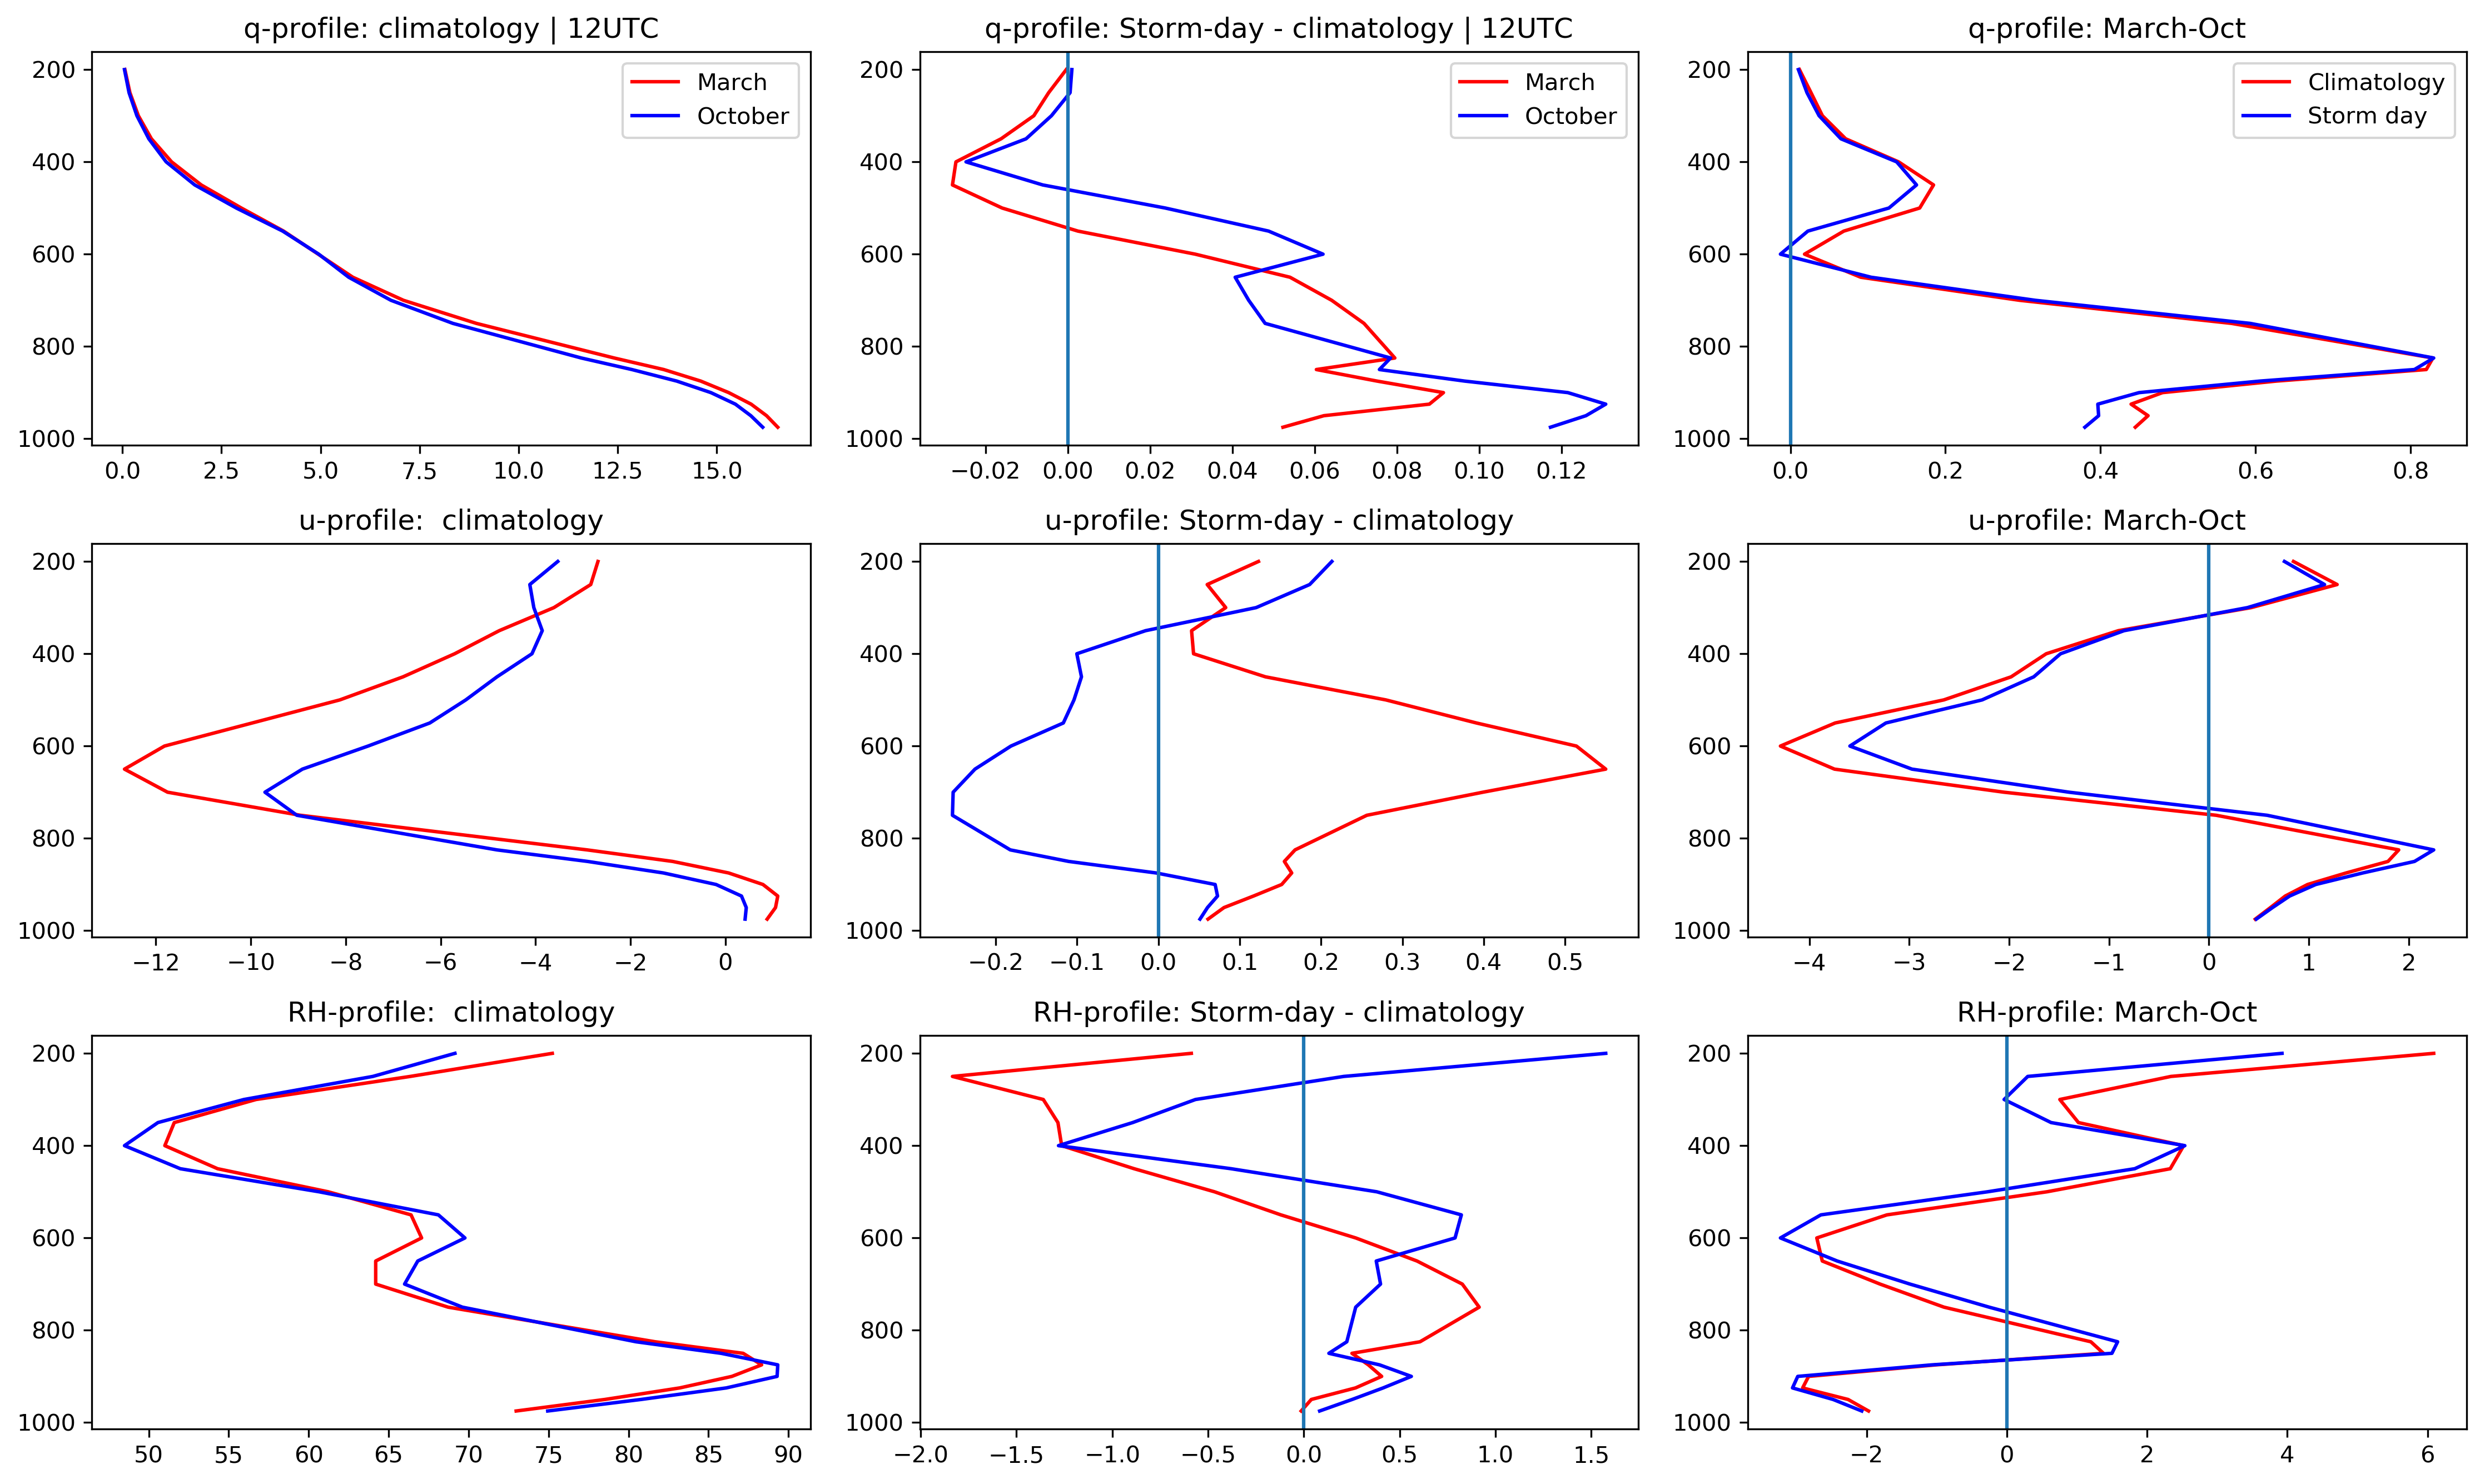

In [224]:
q_march =  np.array(era_march['q_col']).mean(axis=0)*1000 
q_oct =  np.array(era_oct['q_col']).mean(axis=0)*1000 
print(q_march.shape)
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(331)

plt.plot(q_march.squeeze(), era_pl.level.squeeze(),'r', label='March')
plt.plot(q_oct.squeeze(), era_pl.level.squeeze(),'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: climatology | 12UTC')
plt.legend()

q_march =  np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(334)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  climatology')

q_march = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(era_oct['q_col']).mean(axis=0)*1000 - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 

f.add_subplot(332)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Storm-day - climatology | 12UTC')
plt.legend()

q_march = np.array(era_march['u_col']).mean(axis=0) - np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct = np.array(era_oct['u_col']).mean(axis=0) - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(335)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Storm-day - climatology')


q_march = np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000  - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_oct['q_col']).mean(axis=0)*1000
f.add_subplot(333)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(clim_march['u_col']).mean(axis=0).squeeze() - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
q_oct = np.array(era_march['u_col']).mean(axis=0) - np.array(era_oct['u_col']).mean(axis=0)
f.add_subplot(336)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct[sstr]).mean(axis=0).squeeze()
f.add_subplot(337)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = np.array(era_march[sstr]).mean(axis=0) - np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_oct[sstr]).mean(axis=0) - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
f.add_subplot(338)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_march[sstr]).mean(axis=0) - np.array(era_oct[sstr]).mean(axis=0)
f.add_subplot(339)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles.png')

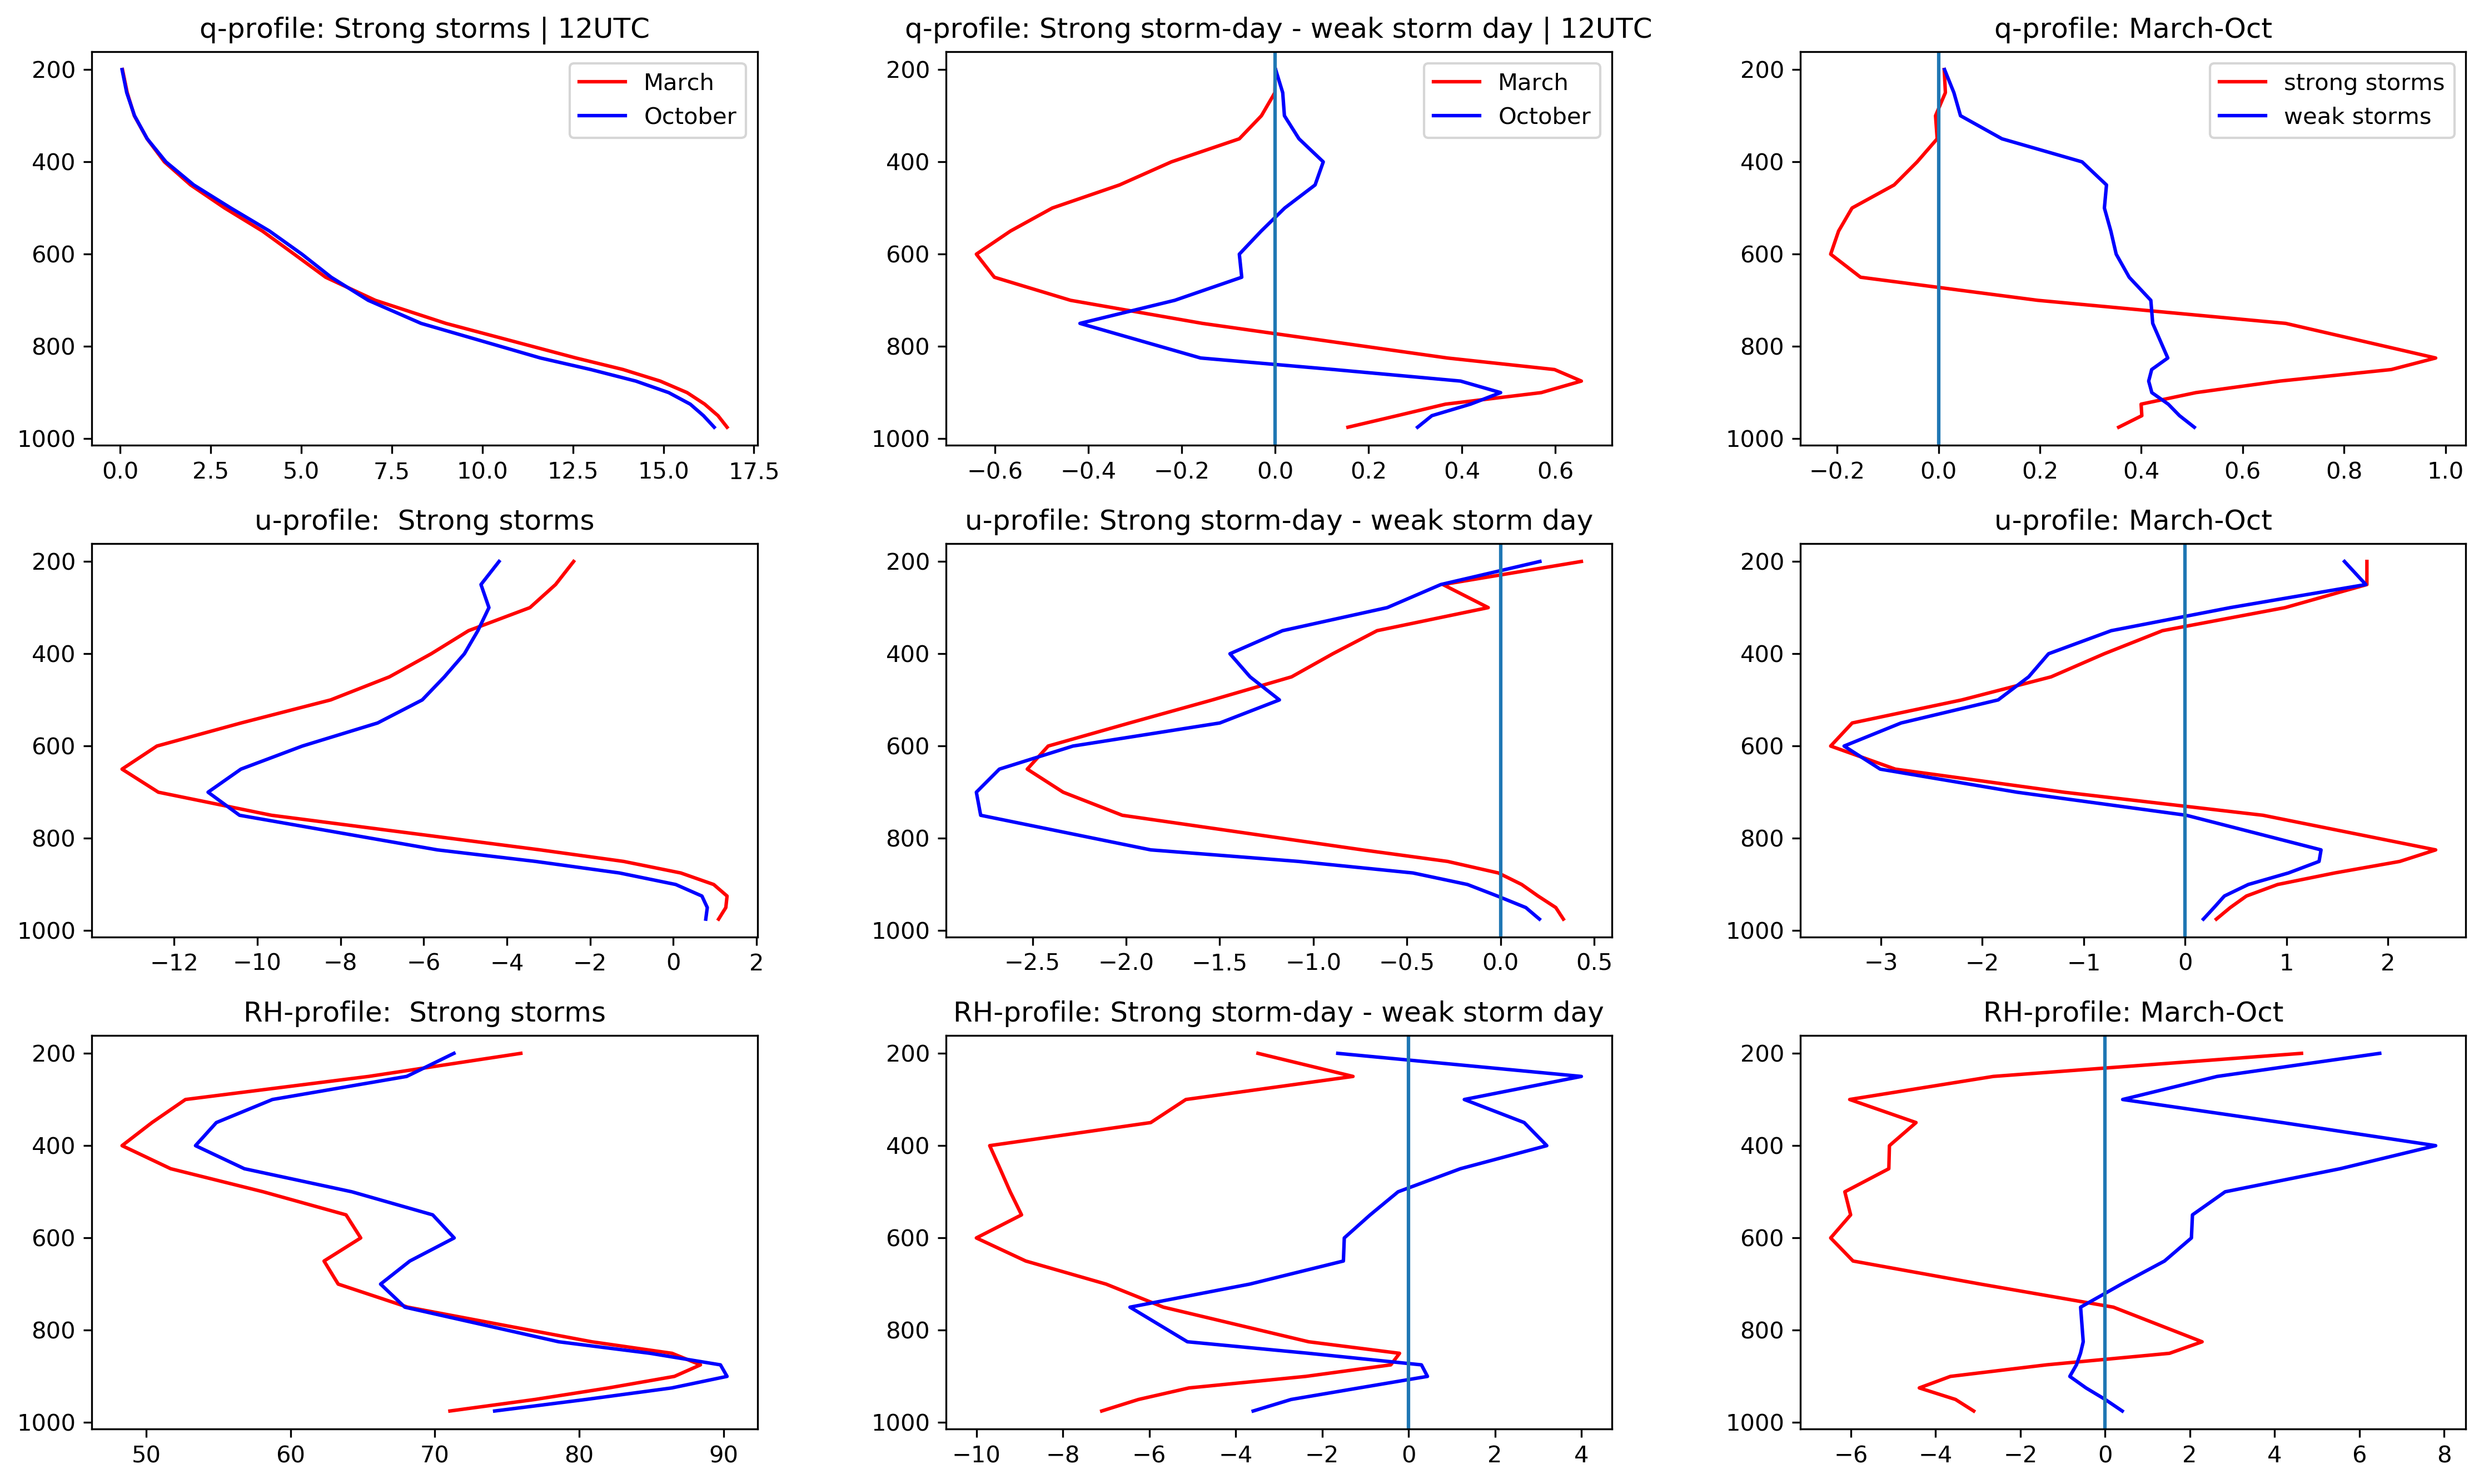

In [225]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(331)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Strong storms | 12UTC')
plt.legend()

q_march =  np.array(mar_strong['u_col']).mean(axis=0)
q_oct =  np.array(oct_strong['u_col']).mean(axis=0)
f.add_subplot(334)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  Strong storms')

q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 

f.add_subplot(332)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Strong storm-day - weak storm day | 12UTC')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(mar_weak['u_col']).mean(axis=0)
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)
f.add_subplot(335)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Strong storm-day - weak storm day')


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000  - np.array(oct_strong['q_col']).mean(axis=0)*1000 
q_oct = np.array(mar_weak['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000
f.add_subplot(333)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(oct_strong['u_col']).mean(axis=0)
q_oct = np.array(mar_weak['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)
f.add_subplot(336)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(mar_strong[sstr]).mean(axis=0)
q_oct =  np.array(oct_strong[sstr]).mean(axis=0)
f.add_subplot(337)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  Strong storms')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(mar_weak[sstr]).mean(axis=0)
q_oct = np.array(oct_strong[sstr]).mean(axis=0) - np.array(oct_weak[sstr]).mean(axis=0)
f.add_subplot(338)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Strong storm-day - weak storm day')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(oct_strong[sstr]).mean(axis=0)
q_oct = np.array(mar_weak[sstr]).mean(axis=0) - np.array(oct_weak[sstr]).mean(axis=0)
f.add_subplot(339)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak.png')

(array([1.676e+03, 4.490e+02, 2.200e+02, 1.270e+02, 9.100e+01, 5.500e+01,
        4.200e+01, 4.000e+01, 2.500e+01, 1.700e+01, 2.000e+01, 1.400e+01,
        9.000e+00, 7.000e+00, 1.100e+01, 1.000e+00, 6.000e+00, 5.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([  5039.65      ,  15897.62533333,  26755.60066667,  37613.576     ,
         48471.55133333,  59329.52666667,  70187.502     ,  81045.47733333,
         91903.45266667, 102761.428     , 113619.40333333, 124477.37866667,
        135335.354     , 146193.32933333, 157051.30466667, 167909.28      ,
        178767.25533333, 189625.23066667, 200483.206     , 211341.18133333,
        222199.15666667, 233057.132     , 243915.10733333, 254773.08266667,
        265631.058     , 276489.03333333, 287347.00866667, 298204.984     ,
        309062.95933333, 319920.93466667, 330778.91      ]),
 <a list of 30 Patch objects>)

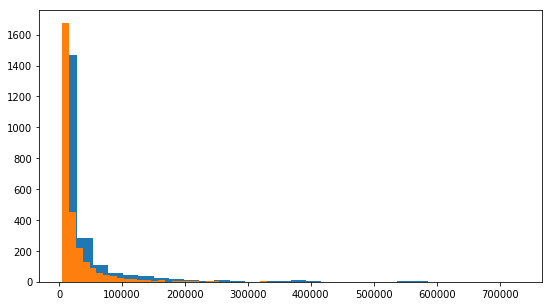

In [226]:
plt.figure(figsize=(9,5))
plt.hist(np.array(era_march['area']), bins=30)
plt.hist(np.array(era_oct['area']), bins=30)

In [227]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show() 

In [ ]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [ ]:
era_pl_cross.ymonth

In [ ]:
cross_march = era_pl_cross.sel(ymonth='3-12')
cross_oct = era_pl_cross.sel(ymonth='10-12')

In [ ]:
era_pl_cross

In [ ]:
cross_march['t'].values-273.15

In [ ]:
ccross_march = cross_march.sel(longitude=slice(-10,10)).mean('longitude')
ccross_oct = cross_oct.sel(longitude=slice(-10,10)).mean('longitude')

In [ ]:
cross_march

In [ ]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

In [ ]:
# temperature and moisture check
data = (ccross_march['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']-ccross_oct['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-2,2,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [ ]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [ ]:
(cross_march)['u']

In [ ]:
lon=cross_march.longitude
lat=cross_march.latitude
map_cross_march = cross_march.sel(level=925)
map_cross_oct = cross_oct.sel(level=925)
data=map_cross_march['t']-map_cross_oct['t']
data2=map_cross_march['q']-map_cross_oct['q']
title=''

contour = {'data' : data2*1000, 'x' : lon, 'y' : lat, 'levels' : np.arange(-3,3,0.4), 'cmap' : 'PuOr'}

# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = map_cross_march.longitude[sarrow::st]
yquiv = map_cross_march.latitude[sarrow::st]

uu = (map_cross_march['u'])[sarrow::st, sarrow::st]
vv = (map_cross_march['v'])[sarrow::st, sarrow::st]


qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}

draw_map(data, lon, lat, title=title, levels=np.linspace(-7,7,8), extend='both', quiver=qin, cmap='RdBu_r', contour=contour, cbar_label= 'mm day$^{-1}$')


In [ ]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'level'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [ ]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count.nc')
era_srfc = uda.flip_lat(era_srfc)
era_pl = uda.flip_lat(era_pl)
era_trend = era_pl.sel(longitude=slice(-10,10)).squeeze().mean('longitude')

In [ ]:
def trends_month(var):
    
    utrend = era_trend[var][(era_trend['time.year']>1982)].groupby('time.month').apply(linear_trend_lingress_2d,nb_missing=10, method='mk')*10
    
    return utrend

In [ ]:
utrend = trends_month('t')

In [ ]:
ccross_march['t'].values = u_met.theta(ccross_march.level.values, ccross_march['t'].values-273.15)

In [ ]:
ccross_march['t'].values

In [ ]:
# temperature and moisture check
data = (ccross_march['t'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.linspace(data.min(),data.max(),10), 'cmap' : 'PuOr'}
draw_cross(utrend.sel(month=3), utrend.latitude, utrend.level, cmap='RdBu_r', contour=contour,
           levels=np.linspace(-0.5,0.5,10), title='Current-past: shading - T, contours - q, vectors: zonal wind')